In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline  

## Generate meta-training and meta-testing data

In [2]:
from experiments.data_sim import SinusoidDataset

random_state = np.random.RandomState(26)
task_environment = SinusoidDataset(random_state=random_state)

meta_train_data = task_environment.generate_meta_train_data(n_tasks=20, n_samples=5)
meta_test_data = task_environment.generate_meta_test_data(n_tasks=20, n_samples_context=5, n_samples_test=50)

# data for visualization
x_plot = np.linspace(-5, 5, num=150)
x_context, y_context, x_test, y_test = meta_test_data[0]

In [3]:
from meta_learn import SparseGPRegressionMetaLearned

meta_gp_sparse = SparseGPRegressionMetaLearned(meta_train_data, weight_decay=0.2, num_iter_fit=12000, random_seed=30, num_inducing_points=5)
meta_gp_sparse.meta_fit(meta_test_data, log_period=1000)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2198.)
  inv_root = torch.triangular_solve(eye, chol)[0]
[2023-12-03 13:35:14,052 -INFO]  Iter 1/12000 - Loss: 6.847073 - Time 0.03 sec - Valid-LL: -1

0.6245088577270508

## Standard GP as a basline

[2023-12-03 13:07:02,434 -INFO]  Iter 1/1000 - Loss: 1.436 - Time 0.003 sec - Valid-LL: -1.315 - Valid-RMSE: 1.402 - Calib-Err 0.290


[2023-12-03 13:07:02,826 -INFO]  Iter 500/1000 - Loss: 1.436 - Time 0.398 sec - Valid-LL: -1.309 - Valid-RMSE: 1.405 - Calib-Err 0.296
[2023-12-03 13:07:03,235 -INFO]  Iter 1000/1000 - Loss: 1.436 - Time 0.409 sec - Valid-LL: -1.309 - Valid-RMSE: 1.405 - Calib-Err 0.296


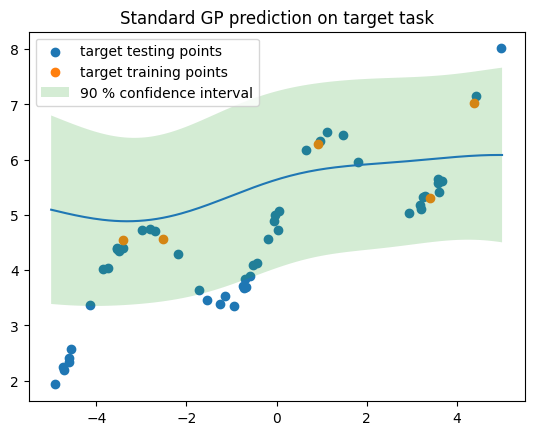

In [ ]:
from meta_learn import GPRegressionLearned

gp = GPRegressionLearned(x_context, y_context, learning_mode='learn_mean', 
                         covar_module='SE', mean_module='constant')
gp.fit(x_test, y_test)

# plot predictions
pred_mean, pred_std = gp.predict(x_plot)
ucb, lcb = gp.confidence_intervals(x_plot, confidence=0.9)

plt.scatter(x_test, y_test, label='target testing points' )
plt.scatter(x_context, y_context, label='target training points')

plt.plot(x_plot, pred_mean)
plt.fill_between(x_plot, lcb, ucb, alpha=0.2, label='90 % confidence interval')
plt.legend()
plt.title("Standard GP prediction on target task")
plt.show()


[2023-12-03 13:07:05,641 -INFO]  Iter 1/1000 - Loss: 1.469 - Time 0.003 sec - Valid-LL: -1.260 - Valid-RMSE: 1.380 - Calib-Err 0.282


[2023-12-03 13:07:06,408 -INFO]  Iter 500/1000 - Loss: 1.468 - Time 0.769 sec - Valid-LL: -1.245 - Valid-RMSE: 1.386 - Calib-Err 0.291
[2023-12-03 13:07:07,164 -INFO]  Iter 1000/1000 - Loss: 1.468 - Time 0.755 sec - Valid-LL: -1.245 - Valid-RMSE: 1.386 - Calib-Err 0.291


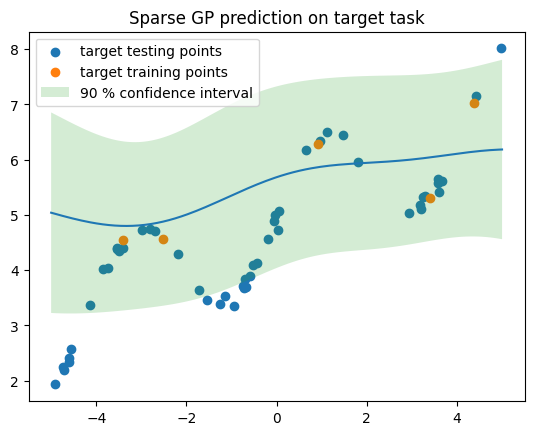

In [ ]:
from meta_learn import SparseGPRegressionLearned

gp = SparseGPRegressionLearned(x_context, y_context, learning_mode='learn_mean', 
                         covar_module='SE', mean_module='constant', random_seed=30)
gp.fit(x_test, y_test)

# plot predictions
pred_mean, pred_std = gp.predict(x_plot)
ucb, lcb = gp.confidence_intervals(x_plot, confidence=0.9)

plt.scatter(x_test, y_test, label='target testing points' )
plt.scatter(x_context, y_context, label='target training points')

plt.plot(x_plot, pred_mean)
plt.fill_between(x_plot, lcb, ucb, alpha=0.2, label='90 % confidence interval')
plt.legend()
plt.title("Sparse GP prediction on target task")
plt.show()

## Meta-Training with PACOH-MAP

In [ ]:
from meta_learn import GPRegressionMetaLearned

meta_gp = GPRegressionMetaLearned(meta_train_data, weight_decay=0.2, num_iter_fit=12000, random_seed=30)
meta_gp.meta_fit(meta_test_data, log_period=1000)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'meta_train_data' is not defined

# Meta-Training with PACOH-MAP (with inducing points, aka sparse GP)

## Meta-Testing with PACOH-MAP

In [ ]:
ll, rmse, calib_err = meta_gp.eval_datasets(meta_test_data)
print('Test log-likelihood:', ll)
print('Test RMSE:', rmse)
print('Test calibration error:', calib_err)

Test log-likelihood: 0.03292174469679594
Test RMSE: 0.3090186148881912
Test calibration error: 0.13442027885466815


In [ ]:
pred_mean, pred_std = meta_gp.predict(x_context, y_context, x_plot)
ucb, lcb = meta_gp.confidence_intervals(x_context, y_context, x_plot, confidence=0.9)

plt.scatter(x_test, y_test, label='target_testing points' )
plt.scatter(x_context, y_context, label='target training points')

plt.plot(x_plot, pred_mean)
plt.fill_between(x_plot, lcb, ucb, alpha=0.2, label='90 % confidence interval')
plt.legend()
plt.title("PACOH-MAP meta-testing prediction on new target task")
plt.show()

NameError: name 'meta_gp' is not defined

In [ ]:
""" A) generate meta-training and meta-testing data """
from experiments.data_sim import SinusoidDataset
task_environment = SinusoidDataset()
meta_train_data = task_environment.generate_meta_train_data(n_tasks=20, n_samples=5)
meta_test_data = task_environment.generate_meta_test_data(n_tasks=20, n_samples_context=5, n_samples_test=50)


""" B) Meta-Learning with PACOH-MAP """
from meta_learn import GPRegressionMetaLearned
meta_gp = GPRegressionMetaLearned(meta_train_data, weight_decay=0.2)
meta_gp.meta_fit(meta_test_data, log_period=1000)


"""  C) Meta-Testing with PACOH-MAP """
x_context, y_context, x_test, y_test = meta_test_data[0]

# target training in (x_ontext, y_context) & predictions for x_test
pred_mean, pred_std = meta_gp.predict(x_context, y_context, x_test)

# confidence intervals predictions in x_test 
ucb, lcb = meta_gp.confidence_intervals(x_context, y_context, x_test, confidence=0.9)

# compute evaluation metrics on one target task
log_likelihood, rmse, calib_error = meta_gp.eval(x_context, y_context, x_test, y_test)

# compute evaluation metrics for multiple tasks / test datasets
log_likelihood, rmse, calib_error = meta_gp.eval_datasets(meta_test_data)

[2023-11-18 16:16:21,128 -INFO]  Iter 1/10000 - Loss: 5.918114 - Time 0.01 sec - Valid-LL: -1.426 - Valid-RMSE: 0.930 - Calib-Err 0.132
[2023-11-18 16:16:25,552 -INFO]  Iter 1000/10000 - Loss: 4.863134 - Time 4.43 sec - Valid-LL: -1.123 - Valid-RMSE: 0.748 - Calib-Err 0.129
[2023-11-18 16:16:30,024 -INFO]  Iter 2000/10000 - Loss: 3.495460 - Time 4.38 sec - Valid-LL: -0.782 - Valid-RMSE: 0.557 - Calib-Err 0.133
[2023-11-18 16:16:34,493 -INFO]  Iter 3000/10000 - Loss: 2.244465 - Time 4.37 sec - Valid-LL: -0.507 - Valid-RMSE: 0.423 - Calib-Err 0.138
[2023-11-18 16:16:39,281 -INFO]  Iter 4000/10000 - Loss: 1.440912 - Time 4.69 sec - Valid-LL: -0.354 - Valid-RMSE: 0.372 - Calib-Err 0.136
[2023-11-18 16:16:43,926 -INFO]  Iter 5000/10000 - Loss: 0.850893 - Time 4.55 sec - Valid-LL: -0.172 - Valid-RMSE: 0.299 - Calib-Err 0.128
[2023-11-18 16:16:48,474 -INFO]  Iter 6000/10000 - Loss: 0.303637 - Time 4.46 sec - Valid-LL: -0.060 - Valid-RMSE: 0.281 - Calib-Err 0.115
[2023-11-18 16:16:52,969 -INFO

# Meta-Testing with PACOH-MAP Sparse GP

In [4]:
ll, rmse, calib_err = meta_gp_sparse.eval_datasets(meta_test_data)
print('Test log-likelihood:', ll)
print('Test RMSE:', rmse)
print('Test calibration error:', calib_err)

Test log-likelihood: -1.281738930940628
Test RMSE: 0.7148898392915726
Test calibration error: 0.17108484134078025


In [5]:
log_likelihoods = []
rmses = []
calib_errors = []
for i in range(5):
    """ A) generate meta-training and meta-testing data """
    from experiments.data_sim import SinusoidDataset
    task_environment = SinusoidDataset()
    meta_train_data = task_environment.generate_meta_train_data(n_tasks=20, n_samples=5)
    meta_test_data = task_environment.generate_meta_test_data(n_tasks=20, n_samples_context=5, n_samples_test=50)


    """ B) Meta-Learning with PACOH-MAP """
    from meta_learn import SparseGPRegressionMetaLearned
    meta_gp = SparseGPRegressionMetaLearned(meta_train_data, weight_decay=0.2, num_inducing_points=3)
    meta_gp.meta_fit(meta_test_data, log_period=1000)


    """  C) Meta-Testing with PACOH-MAP """
    x_context, y_context, x_test, y_test = meta_test_data[0]

    # target training in (x_ontext, y_context) & predictions for x_test
    pred_mean, pred_std = meta_gp.predict(x_context, y_context, x_test)

    # confidence intervals predictions in x_test 
    ucb, lcb = meta_gp.confidence_intervals(x_context, y_context, x_test, confidence=0.9)

    # compute evaluation metrics on one target task
    log_likelihood, rmse, calib_error = meta_gp.eval(x_context, y_context, x_test, y_test)

    # compute evaluation metrics for multiple tasks / test datasets
    log_likelihood, rmse, calib_error = meta_gp.eval_datasets(meta_test_data)
    log_likelihoods.append(log_likelihood)
    rmses.append(rmse)
    calib_errors.append(calib_error)
# calculate mean and std of metrics
log_likelihoods = np.array(log_likelihoods)
rmses = np.array(rmses)
calib_errors = np.array(calib_errors)
print('Test log-likelihood:', log_likelihoods.mean(), log_likelihoods.std())
print('Test RMSE:', rmses.mean(), rmses.std())
print('Test calibration error:', calib_errors.mean(), calib_errors.std())

[2023-12-03 13:11:34,100 -INFO]  Iter 1/10000 - Loss: 8.187512 - Time 0.02 sec - Valid-LL: -1.417 - Valid-RMSE: 1.380 - Calib-Err 0.114
[2023-12-03 13:11:41,760 -INFO]  Iter 1000/10000 - Loss: 7.338306 - Time 7.67 sec - Valid-LL: -1.451 - Valid-RMSE: 1.145 - Calib-Err 0.120
[2023-12-03 13:11:49,435 -INFO]  Iter 2000/10000 - Loss: 7.241185 - Time 7.48 sec - Valid-LL: -1.508 - Valid-RMSE: 1.097 - Calib-Err 0.128
[2023-12-03 13:11:56,976 -INFO]  Iter 3000/10000 - Loss: 7.166840 - Time 7.35 sec - Valid-LL: -1.420 - Valid-RMSE: 1.055 - Calib-Err 0.127
[2023-12-03 13:12:04,683 -INFO]  Iter 4000/10000 - Loss: 7.097002 - Time 7.52 sec - Valid-LL: -1.437 - Valid-RMSE: 1.050 - Calib-Err 0.130
[2023-12-03 13:12:11,916 -INFO]  Iter 5000/10000 - Loss: 7.034843 - Time 7.05 sec - Valid-LL: -1.396 - Valid-RMSE: 1.037 - Calib-Err 0.131
[2023-12-03 13:12:19,550 -INFO]  Iter 6000/10000 - Loss: 6.982056 - Time 7.45 sec - Valid-LL: -1.356 - Valid-RMSE: 0.944 - Calib-Err 0.141
[2023-12-03 13:12:26,667 -INFO

Test log-likelihood: -1.3217637073993682 0.08042284420722455
Test RMSE: 0.6412345853447914 0.08634322321051846
Test calibration error: 0.18692456051707268 0.014651227700344363


In [ ]:
print(log_likelihood, rmse, calib_error)

-1.5366127848625184 0.7807456210255623 0.1920651700347662
